**PHASE 4: ANALYSIS - Cluster Characterization**

Purpose: Extract cluster profiles (top terms, categories, temporal, quality indicators)  
Input: cluster_labels_{SVD_VARIANT}.pkl, tfidf_matrix.pkl, metadata  
Output: cluster_profiles_{SVD_VARIANT}.pkl, comprehensive characterization files  
Algorithm: Descriptive statistics, aggregation, top-k extraction  
ML Involved: ✗ NO - Pure analysis of clustering results  
Runtime: ~15-20 minutes per variant  

Configuration: Set SVD_VARIANT at top of notebook
- Run cells 1-11 for first variant
- STOP at markdown, change config, rerun cells 1-11 for second variant
- Then run cells 12-14 for comparison (if desired)

In [1]:
# imports

import pandas as pd
import numpy as np
import os
import sys
import joblib
from collections import Counter
from datetime import datetime

# add project root to path

sys.path.append('..')
from config import RANDOM_STATE

print("✓ All imports loaded")

✓ All imports loaded


In [12]:
# configuration, set for each path

SVD_VARIANT = "500d"  # Options: "300d" or "500d"

print(f"CLUSTER CHARACTERIZATION FOR SVD-{SVD_VARIANT.upper()}")

CLUSTER CHARACTERIZATION FOR SVD-500D


In [13]:
# load cluster assignments

print(f"\nLoading data for {SVD_VARIANT}...")
labels_df = pd.read_pickle(f'data/processed/cluster_labels_{SVD_VARIANT}.pkl')
print(f"✓ Loaded cluster labels: {len(labels_df):,} papers")

# load clustering metrics

metrics = joblib.load(f'data/processed/clustering_metrics_{SVD_VARIANT}.pkl')
n_clusters = metrics['k']
print(f"✓ Number of clusters: {n_clusters}")

# load metadata

df_metadata = pd.read_pickle('data/processed/arxiv_text_cleaned.pkl')
print(f"✓ Loaded metadata: {len(df_metadata):,} papers")

# load TF-IDF data

tfidf_matrix = joblib.load('data/processed/tfidf_matrix.pkl')
vectorizer = joblib.load('data/processed/tfidf_vectorizer.pkl')
feature_names = vectorizer.get_feature_names_out()
print(f"✓ Loaded TF-IDF: {tfidf_matrix.shape}")

# merge cluster labels with metadata

df = df_metadata.merge(labels_df, on='id', how='left')
print(f"✓ Merged data: {len(df):,} papers")

# verify no missing clusters

missing = df['cluster_id'].isna().sum()
if missing > 0:
    print(f"⚠ Warning: {missing} papers missing cluster assignments")
else:
    print("✓ All papers have cluster assignments")


Loading data for 500d...
✓ Loaded cluster labels: 2,384,622 papers
✓ Number of clusters: 50
✓ Loaded metadata: 2,384,622 papers
✓ Loaded TF-IDF: (2384622, 1000)
✓ Merged data: 2,384,622 papers
✓ All papers have cluster assignments


In [14]:
# extract top terms for each cluster

print("\nExtracting top terms per cluster...")

top_terms_per_cluster = {}

for cluster_id in range(n_clusters):
    # get papers in this cluster
    cluster_mask = df['cluster_id'] == cluster_id
    cluster_indices = df[cluster_mask].index
    
    # calculate mean TF-IDF scores
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
    cluster_tfidf_array = np.asarray(cluster_tfidf).flatten()
    
    # get top 30 terms
    top_indices = cluster_tfidf_array.argsort()[-30:][::-1]
    top_terms = [(feature_names[i], cluster_tfidf_array[i]) for i in top_indices]
    
    top_terms_per_cluster[cluster_id] = top_terms
    
    if (cluster_id + 1) % 10 == 0:
        print(f"  Processed {cluster_id + 1}/{n_clusters} clusters")

print(f"✓ Extracted top terms for {n_clusters} clusters")


Extracting top terms per cluster...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters
✓ Extracted top terms for 50 clusters


In [15]:
# extract category information per cluster

print("\nExtracting category distributions...")

top_categories_per_cluster = {}

for cluster_id in range(n_clusters):
    cluster_papers = df[df['cluster_id'] == cluster_id]
    
    # primary categories
    primary_cats = cluster_papers['primary_category'].value_counts().head(10)
    
    # all categories (multi-category analysis)
    all_cats = []
    for cats in cluster_papers['all_categories']:
        if isinstance(cats, list):
            all_cats.extend(cats)
        else:
            all_cats.append(cats)
    all_cat_counts = Counter(all_cats)
    
    # top-level domains
    domains = cluster_papers['top_level_domain'].value_counts().head(5)
    
    # category diversity
    n_unique_categories = cluster_papers['primary_category'].nunique()
    
    top_categories_per_cluster[cluster_id] = {
        'primary_categories': primary_cats.to_dict(),
        'all_categories': dict(all_cat_counts.most_common(15)),
        'domains': domains.to_dict(),
        'n_unique_categories': n_unique_categories,
        'size': len(cluster_papers)
    }
    
    if (cluster_id + 1) % 10 == 0:
        print(f"  Processed {cluster_id + 1}/{n_clusters} clusters")

print(f"✓ Extracted categories for {n_clusters} clusters")


Extracting category distributions...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters
✓ Extracted categories for 50 clusters


In [16]:
# analyze temporal patterns

print("\nAnalyzing temporal distributions...")

temporal_per_cluster = {}

for cluster_id in range(n_clusters):
    cluster_papers = df[df['cluster_id'] == cluster_id]
    
    # year distribution
    year_dist = cluster_papers['year'].value_counts().sort_index()
    
    # recency metrics
    total_papers = len(cluster_papers)
    recent_papers = len(cluster_papers[cluster_papers['year'] >= 2020])
    recency_ratio = recent_papers / total_papers if total_papers > 0 else 0
    
    temporal_per_cluster[cluster_id] = {
        'year_distribution': year_dist.to_dict(),
        'earliest_year': cluster_papers['year'].min(),
        'latest_year': cluster_papers['year'].max(),
        'median_year': cluster_papers['year'].median(),
        'recent_ratio': recency_ratio,
        'size': total_papers
    }
    
    if (cluster_id + 1) % 10 == 0:
        print(f"  Processed {cluster_id + 1}/{n_clusters} clusters")

print(f"✓ Analyzed temporal patterns for {n_clusters} clusters")


Analyzing temporal distributions...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters
✓ Analyzed temporal patterns for 50 clusters


In [17]:
# calculate comprehensive cluster quality indicators

print("\nCalculating cluster quality indicators...")

quality_per_cluster = {}

for cluster_id in range(n_clusters):
    cluster_papers = df[df['cluster_id'] == cluster_id]
    cluster_indices = cluster_papers.index
    size = len(cluster_papers)
    
    # basic quality signals
    journal_rate = cluster_papers['has_journal'].mean()
    multi_cat_rate = cluster_papers['is_multi_category'].mean()
    avg_authors = cluster_papers['num_authors'].mean()
    
    # domain diversity (shannon entropy)
    domain_counts = cluster_papers['top_level_domain'].value_counts()
    domain_probs = domain_counts / size
    from scipy.stats import entropy
    domain_diversity = entropy(domain_probs)
    
    # category purity
    top_cat_count = cluster_papers['primary_category'].value_counts().iloc[0]
    category_purity = top_cat_count / size
    
    # temporal velocity (growth rate)
    recent_count = len(cluster_papers[cluster_papers['year'] >= 2022])
    older_count = len(cluster_papers[cluster_papers['year'].between(2019, 2021)])
    growth_rate = (recent_count - older_count) / older_count if older_count > 0 else 0
    
    # TF-IDF distinctiveness
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
    corpus_tfidf = tfidf_matrix.mean(axis=0)
    
    from sklearn.metrics.pairwise import cosine_similarity
    cluster_vec = np.asarray(cluster_tfidf).flatten().reshape(1, -1)
    corpus_vec = np.asarray(corpus_tfidf).flatten().reshape(1, -1)
    distinctiveness = 1 - cosine_similarity(cluster_vec, corpus_vec)[0, 0]
    
    # niche score (small + recent)
    recent_ratio = len(cluster_papers[cluster_papers['year'] >= 2020]) / size
    size_score = 1 / (1 + np.log(size))
    niche_score = size_score * recent_ratio
    
    quality_per_cluster[cluster_id] = {
        'journal_rate': journal_rate,
        'multi_category_rate': multi_cat_rate,
        'avg_authors': avg_authors,
        'domain_diversity': domain_diversity,
        'category_purity': category_purity,
        'growth_rate': growth_rate,
        'distinctiveness': distinctiveness,
        'niche_score': niche_score,
        'size': size
    }
    
    if (cluster_id + 1) % 10 == 0:
        print(f"  Processed {cluster_id + 1}/{n_clusters} clusters")

print(f"✓ Calculated quality indicators for {n_clusters} clusters")


Calculating cluster quality indicators...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters
✓ Calculated quality indicators for 50 clusters


In [18]:
# show profiles for first 3 clusters as preview

print(f"SAMPLE CLUSTER PROFILES (First 3 Clusters) - {SVD_VARIANT.upper()}")

for cluster_id in range(min(3, n_clusters)):
    print(f"CLUSTER {cluster_id}")
    
    # size
    size = top_categories_per_cluster[cluster_id]['size']
    pct = size / len(df) * 100
    print(f"Size: {size:,} papers ({pct:.1f}%)")
    
    # top terms
    print(f"\nTop 15 terms:")
    for i, (term, score) in enumerate(top_terms_per_cluster[cluster_id][:15], 1):
        print(f"  {i:2d}. {term:25s} (score: {score:.4f})")
    
    # top categories
    print(f"\nTop 5 ArXiv categories:")
    for cat, count in list(top_categories_per_cluster[cluster_id]['primary_categories'].items())[:5]:
        cat_pct = count / size * 100
        print(f"  {cat:20s} {count:>6,} papers ({cat_pct:>5.1f}%)")
    
    # top domains
    print(f"\nTop domains:")
    for domain, count in top_categories_per_cluster[cluster_id]['domains'].items():
        domain_pct = count / size * 100
        print(f"  {domain:10s} {count:>6,} papers ({domain_pct:>5.1f}%)")
    
    # temporal info
    temporal = temporal_per_cluster[cluster_id]
    print(f"\nTemporal:")
    print(f"  Year range: {temporal['earliest_year']}-{temporal['latest_year']}")
    print(f"  Median year: {temporal['median_year']:.0f}")
    print(f"  Recent papers (2020+): {temporal['recent_ratio']*100:.1f}%")
    
    # quality indicators
    quality = quality_per_cluster[cluster_id]
    print(f"\nQuality indicators:")
    print(f"  Journal rate: {quality['journal_rate']*100:.1f}%")
    print(f"  Multi-category: {quality['multi_category_rate']*100:.1f}%")
    print(f"  Avg authors: {quality['avg_authors']:.1f}")
    print(f"  Domain diversity: {quality['domain_diversity']:.3f}")
    print(f"  Category purity: {quality['category_purity']*100:.1f}%")
    print(f"  Growth rate: {quality['growth_rate']*100:+.1f}%")
    print(f"  Distinctiveness: {quality['distinctiveness']:.3f}")
    print(f"  Niche score: {quality['niche_score']:.4f}")

SAMPLE CLUSTER PROFILES (First 3 Clusters) - 500D
CLUSTER 0
Size: 40,304 papers (1.7%)

Top 15 terms:
   1. group                     (score: 0.2734)
   2. groups                    (score: 0.2005)
   3. finite                    (score: 0.0606)
   4. prove                     (score: 0.0390)
   5. lie                       (score: 0.0317)
   6. let                       (score: 0.0273)
   7. theory                    (score: 0.0254)
   8. action                    (score: 0.0253)
   9. class                     (score: 0.0247)
  10. representations           (score: 0.0242)
  11. space                     (score: 0.0241)
  12. algebraic                 (score: 0.0235)
  13. non                       (score: 0.0235)
  14. compact                   (score: 0.0234)
  15. paper                     (score: 0.0233)

Top 5 ArXiv categories:
  math.GR               8,559 papers ( 21.2%)
  math.AG               3,604 papers (  8.9%)
  math.RT               3,005 papers (  7.5%)
  math.GT      

In [19]:
# save comprehensive cluster profiles

print("\nSaving cluster profiles...")

profiles_path = f'data/processed/cluster_profiles_{SVD_VARIANT}.pkl'

cluster_profiles = {
    'top_terms': top_terms_per_cluster,
    'top_categories': top_categories_per_cluster,
    'temporal': temporal_per_cluster,
    'quality': quality_per_cluster,
    'n_clusters': n_clusters,
    'total_papers': len(df),
    'svd_variant': SVD_VARIANT
}

joblib.dump(cluster_profiles, profiles_path)
print(f"✓ Saved cluster profiles: {profiles_path}")


Saving cluster profiles...
✓ Saved cluster profiles: data/processed/cluster_profiles_500d.pkl


In [20]:
# save readable characterization summary

summary_path = f'results/cluster_characterization_{SVD_VARIANT}.txt'

with open(summary_path, 'w') as f:
    f.write(f"CLUSTER CHARACTERIZATION SUMMARY: SVD-{SVD_VARIANT.upper()}\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"SVD variant: {SVD_VARIANT}\n")
    f.write(f"Number of clusters: {n_clusters}\n")
    f.write(f"Total papers: {len(df):,}\n\n")
    
    # summary statistics
    f.write("OVERALL STATISTICS\n")
    
    avg_size = np.mean([q['size'] for q in quality_per_cluster.values()])
    avg_purity = np.mean([q['category_purity'] for q in quality_per_cluster.values()])
    avg_diversity = np.mean([q['domain_diversity'] for q in quality_per_cluster.values()])
    avg_distinctiveness = np.mean([q['distinctiveness'] for q in quality_per_cluster.values()])
    
    f.write(f"Average cluster size: {avg_size:,.0f} papers\n")
    f.write(f"Average category purity: {avg_purity*100:.1f}%\n")
    f.write(f"Average domain diversity: {avg_diversity:.3f}\n")
    f.write(f"Average distinctiveness: {avg_distinctiveness:.3f}\n\n")
    
    # individual cluster profiles
    f.write("-"*80 + "\n")
    f.write("INDIVIDUAL CLUSTER PROFILES\n")
    f.write("-"*80 + "\n\n")
    
    for cluster_id in range(n_clusters):
        f.write("="*80 + "\n")
        f.write(f"CLUSTER {cluster_id}\n")
        f.write("="*80 + "\n")
        
        # size
        size = top_categories_per_cluster[cluster_id]['size']
        pct = size / len(df) * 100
        f.write(f"Size: {size:,} papers ({pct:.2f}%)\n\n")
        
        # top 20 terms
        f.write("Top 20 terms:\n")
        for i, (term, score) in enumerate(top_terms_per_cluster[cluster_id][:20], 1):
            f.write(f"  {i:2d}. {term:25s} (score: {score:.4f})\n")
        
        # top 10 categories
        f.write(f"\nTop 10 ArXiv categories:\n")
        for cat, count in list(top_categories_per_cluster[cluster_id]['primary_categories'].items())[:10]:
            cat_pct = count / size * 100
            f.write(f"  {cat:20s} {count:>6,} papers ({cat_pct:>6.2f}%)\n")
        
        # domains
        f.write(f"\nDomain distribution:\n")
        for domain, count in top_categories_per_cluster[cluster_id]['domains'].items():
            domain_pct = count / size * 100
            f.write(f"  {domain:10s} {count:>6,} papers ({domain_pct:>6.2f}%)\n")
        
        # temporal
        temporal = temporal_per_cluster[cluster_id]
        f.write(f"\nTemporal characteristics:\n")
        f.write(f"  Year range: {temporal['earliest_year']}-{temporal['latest_year']}\n")
        f.write(f"  Median year: {temporal['median_year']:.0f}\n")
        f.write(f"  Recent papers (2020+): {temporal['recent_ratio']*100:.1f}%\n")
        
        # quality
        quality = quality_per_cluster[cluster_id]
        f.write(f"\nQuality indicators:\n")
        f.write(f"  Category purity: {quality['category_purity']*100:.1f}%\n")
        f.write(f"  Domain diversity: {quality['domain_diversity']:.3f}\n")
        f.write(f"  Distinctiveness: {quality['distinctiveness']:.3f}\n")
        f.write(f"  Growth rate: {quality['growth_rate']*100:+.1f}%\n")
        f.write(f"  Niche score: {quality['niche_score']:.4f}\n")
        f.write(f"  Journal rate: {quality['journal_rate']*100:.1f}%\n")
        f.write(f"  Multi-category rate: {quality['multi_category_rate']*100:.1f}%\n")
        f.write(f"  Avg authors: {quality['avg_authors']:.1f}\n")
        f.write("\n")

print(f"✓ Saved characterization summary: {summary_path}")

✓ Saved characterization summary: results/cluster_characterization_500d.txt


In [21]:
# verify files for this variant

files_to_check = [
    f'data/processed/cluster_profiles_{SVD_VARIANT}.pkl',
    f'results/cluster_characterization_{SVD_VARIANT}.txt'
]

print(f"VERIFYING OUTPUTS FOR {SVD_VARIANT.upper()}")

all_good = True
for file_path in files_to_check:
    if os.path.exists(file_path):
        if file_path.endswith('.pkl'):
            size_mb = os.path.getsize(file_path) / 1024**2
            print(f"✓ {file_path}")
            print(f"  Size: {size_mb:.2f} MB")
        else:
            lines = sum(1 for _ in open(file_path))
            print(f"✓ {file_path}")
            print(f"  Lines: {lines:,}")
    else:
        print(f"x Missing: {file_path}")
        all_good = False

if all_good:
    print(f"✓✓✓ Success! ✓✓✓- All files created for {SVD_VARIANT.upper()}")
    print(f"\nCharacterization complete for {n_clusters} clusters")
else:
    print(f"\nx Error - Some files missing for {SVD_VARIANT.upper()}!")

VERIFYING OUTPUTS FOR 500D
✓ data/processed/cluster_profiles_500d.pkl
  Size: 0.07 MB
✓ results/cluster_characterization_500d.txt
  Lines: 3,066
✓✓✓ Success! ✓✓✓- All files created for 500D

Characterization complete for 50 clusters


---
## ⚠️ STOP HERE - CHANGE CONFIGURATION FOR SECOND PATH

**You just completed characterization for:** `SVD_VARIANT = "{SVD_VARIANT}"`

**Before proceeding to comparison (Cell 12+):**

1. **Change configuration in Cell 1:**
   - Update `SVD_VARIANT` to the OTHER value ("300d" → "500d" or vice versa)

2. **Restart kernel** (to clear variables)

3. **Run cells 1-10 again** for the second variant

4. **Verify you have BOTH complete:**
   - ✓ `cluster_profiles_300d.pkl`
   - ✓ `cluster_profiles_500d.pkl`
   - ✓ `cluster_characterization_300d.txt`
   - ✓ `cluster_characterization_500d.txt`

5. **Then continue to Cell 12** for comparison analysis

**DO NOT proceed until both variants are characterized!**

In [22]:
# verify both characterization variants completed

print("Checking for both characterization results...")

required_files = {
    '300d': [
        'data/processed/cluster_profiles_300d.pkl',
        'results/cluster_characterization_300d.txt'
    ],
    '500d': [
        'data/processed/cluster_profiles_500d.pkl',
        'results/cluster_characterization_500d.txt'
    ]
}

status = {'300d': True, '500d': True}

for variant, files in required_files.items():
    print(f"\n{variant.upper()} files:")
    for filepath in files:
        if os.path.exists(filepath):
            print(f"  ✓ {filepath}")
        else:
            print(f"  x Missing: {filepath}")
            status[variant] = False


missing_variants = [v for v, complete in status.items() if not complete]

if missing_variants:
    print(f"\nx Error: Incomplete characterization for: {', '.join(missing_variants)}")
    print("\nGo back and run cells 1-10 for missing variant(s)")
    raise FileNotFoundError("Complete both characterization variants before comparison")
else:
    print("\n Success!: Both characterization variants found!")
    print("Proceeding to comparison analysis...")

Checking for both characterization results...

300D files:
  ✓ data/processed/cluster_profiles_300d.pkl
  ✓ results/cluster_characterization_300d.txt

500D files:
  ✓ data/processed/cluster_profiles_500d.pkl
  ✓ results/cluster_characterization_500d.txt

 Success!: Both characterization variants found!
Proceeding to comparison analysis...


In [ ]:
# load both characterization profiles

print("\nLoading characterization profiles for comparison...")

profiles_300d = joblib.load('data/processed/cluster_profiles_300d.pkl')
profiles_500d = joblib.load('data/processed/cluster_profiles_500d.pkl')

print(f"✓ Loaded 300d profiles: {profiles_300d['n_clusters']} clusters")
print(f"✓ Loaded 500d profiles: {profiles_500d['n_clusters']} clusters")

# load cluster assignments for overlap analysis

labels_300d = pd.read_pickle('data/processed/cluster_labels_300d.pkl')
labels_500d = pd.read_pickle('data/processed/cluster_labels_500d.pkl')

# merge to compare assignments

comparison_df = labels_300d.merge(labels_500d, on='id', suffixes=('_300d', '_500d'))
print(f"✓ Loaded cluster assignments: {len(comparison_df):,} papers")

# calculate cluster overlap (adjusted rand index)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(comparison_df['cluster_id_300d'], 
                           comparison_df['cluster_id_500d'])
nmi = normalized_mutual_info_score(comparison_df['cluster_id_300d'], 
                                     comparison_df['cluster_id_500d'])

print("CLUSTER ASSIGNMENT OVERLAP")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  (1.0 = identical, 0.0 = random, <0 = worse than random)")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"  (1.0 = identical, 0.0 = independent)")

# calculate correspondence matrix (which 300d clusters map to which 500d?)

print(f"\nCalculating cluster correspondence matrix...")
correspondence = pd.crosstab(comparison_df['cluster_id_300d'], 
                              comparison_df['cluster_id_500d'])
print(f"✓ Correspondence matrix: {correspondence.shape}")

# for each 300d cluster, find best matching 500d cluster

best_matches_300_to_500 = {}
for cluster_300 in range(profiles_300d['n_clusters']):
    if cluster_300 in correspondence.index:
        best_match = correspondence.loc[cluster_300].idxmax()
        overlap_count = correspondence.loc[cluster_300, best_match]
        total_in_300 = correspondence.loc[cluster_300].sum()
        overlap_pct = overlap_count / total_in_300 * 100
        
        best_matches_300_to_500[cluster_300] = {
            'best_500d_match': int(best_match),
            'overlap_count': int(overlap_count),
            'total_in_300d': int(total_in_300),
            'overlap_pct': overlap_pct
        }

print(f"✓ Calculated best matches for all 300d clusters")


Loading characterization profiles for comparison...
------------------------------------------------------------
✓ Loaded 300d profiles: 50 clusters
✓ Loaded 500d profiles: 50 clusters
✓ Loaded cluster assignments: 2,384,622 papers

CLUSTER ASSIGNMENT OVERLAP
Adjusted Rand Index (ARI): 0.3600
  (1.0 = identical, 0.0 = random, <0 = worse than random)
Normalized Mutual Information (NMI): 0.6233
  (1.0 = identical, 0.0 = independent)

Calculating cluster correspondence matrix...
✓ Correspondence matrix: (50, 50)
✓ Calculated best matches for all 300d clusters



✓ Saved comparison figure: results/figures/cluster_characterization_comparison.png


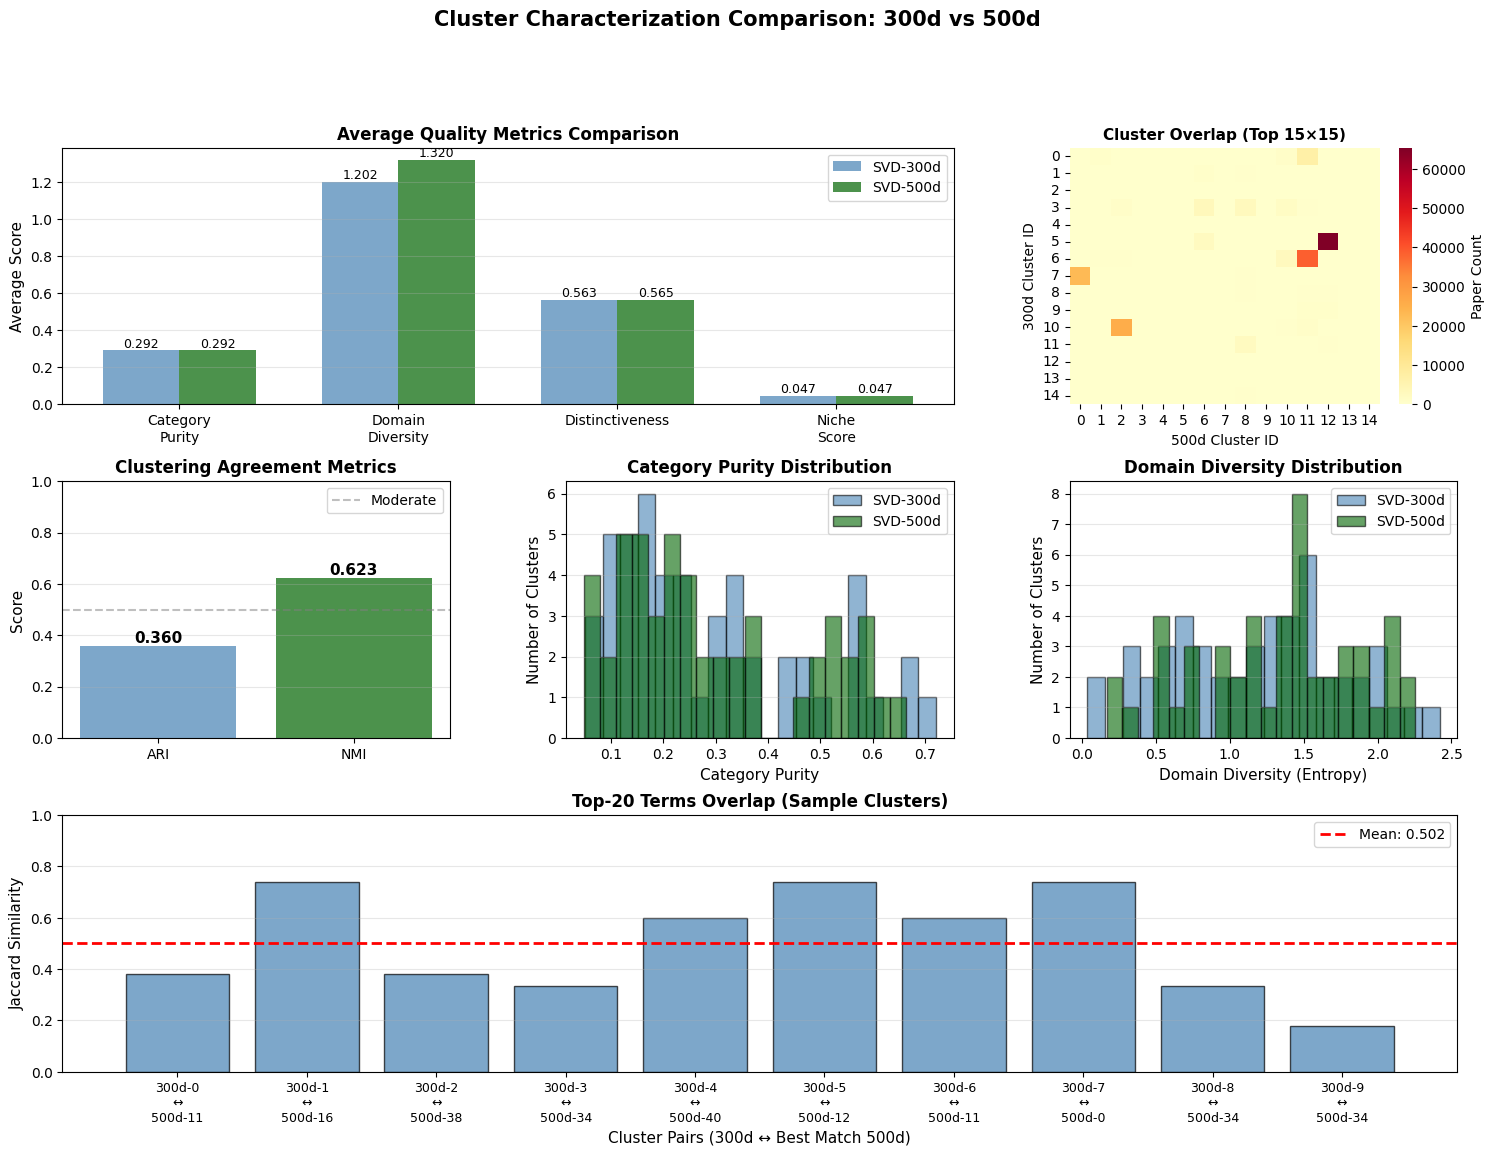

COMPARISON SUMMARY STATISTICS

Average Quality Metrics:
Metric                    300d            500d            Difference
------------------------------------------------------------
Category Purity           0.2923          0.2923          -0.0000
Domain Diversity          1.2017          1.3197          -0.1180
Distinctiveness           0.5630          0.5651          -0.0022
Niche Score               0.0469          0.0471          -0.0002

Top Terms Similarity:
  Mean Jaccard (sample): 0.502
  Min Jaccard: 0.176
  Max Jaccard: 0.739


In [25]:
# create comprehensive comparison visualizations

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# plot 1: quality metrics comparison (box plots)

ax1 = fig.add_subplot(gs[0, :2])

quality_metrics = ['category_purity', 'domain_diversity', 'distinctiveness', 'niche_score']
quality_labels = ['Category\nPurity', 'Domain\nDiversity', 'Distinctiveness', 'Niche\nScore']

data_300d = {metric: [profiles_300d['quality'][cid][metric] 
                       for cid in range(profiles_300d['n_clusters'])] 
             for metric in quality_metrics}
data_500d = {metric: [profiles_500d['quality'][cid][metric] 
                       for cid in range(profiles_500d['n_clusters'])] 
             for metric in quality_metrics}

x_pos = np.arange(len(quality_metrics))
width = 0.35

# calculate means for bar chart

means_300d = [np.mean(data_300d[m]) for m in quality_metrics]
means_500d = [np.mean(data_500d[m]) for m in quality_metrics]

bars1 = ax1.bar(x_pos - width/2, means_300d, width, label='SVD-300d', 
                color='steelblue', alpha=0.7)
bars2 = ax1.bar(x_pos + width/2, means_500d, width, label='SVD-500d', 
                color='darkgreen', alpha=0.7)

# add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(quality_labels)
ax1.set_ylabel('Average Score', fontsize=11)
ax1.set_title('Average Quality Metrics Comparison', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# plot 2: cluster assignment overlap heatmap (top 15x15)

ax2 = fig.add_subplot(gs[0, 2])

# show top 15 clusters from each path

top_n = 15
correspondence_subset = correspondence.iloc[:top_n, :top_n]

sns.heatmap(correspondence_subset, cmap='YlOrRd', annot=False, 
            fmt='d', cbar_kws={'label': 'Paper Count'}, ax=ax2)
ax2.set_xlabel('500d Cluster ID', fontsize=10)
ax2.set_ylabel('300d Cluster ID', fontsize=10)
ax2.set_title(f'Cluster Overlap (Top {top_n}×{top_n})', fontsize=11, fontweight='bold')

# plot 3: ARI/NMI scores

ax3 = fig.add_subplot(gs[1, 0])

metrics_scores = [ari, nmi]
metrics_names = ['ARI', 'NMI']
colors = ['steelblue', 'darkgreen']

bars = ax3.bar(metrics_names, metrics_scores, color=colors, alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3.set_ylim(0, 1)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Clustering Agreement Metrics', fontsize=12, fontweight='bold')
ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Moderate')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# plot 4: category purity distribution

ax4 = fig.add_subplot(gs[1, 1])

purity_300d = [profiles_300d['quality'][i]['category_purity'] 
               for i in range(profiles_300d['n_clusters'])]
purity_500d = [profiles_500d['quality'][i]['category_purity'] 
               for i in range(profiles_500d['n_clusters'])]

ax4.hist(purity_300d, bins=20, alpha=0.6, label='SVD-300d', color='steelblue', edgecolor='black')
ax4.hist(purity_500d, bins=20, alpha=0.6, label='SVD-500d', color='darkgreen', edgecolor='black')
ax4.set_xlabel('Category Purity', fontsize=11)
ax4.set_ylabel('Number of Clusters', fontsize=11)
ax4.set_title('Category Purity Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# plot 5: domain diversity distribution

ax5 = fig.add_subplot(gs[1, 2])

diversity_300d = [profiles_300d['quality'][i]['domain_diversity'] 
                  for i in range(profiles_300d['n_clusters'])]
diversity_500d = [profiles_500d['quality'][i]['domain_diversity'] 
                  for i in range(profiles_500d['n_clusters'])]

ax5.hist(diversity_300d, bins=20, alpha=0.6, label='SVD-300d', color='steelblue', edgecolor='black')
ax5.hist(diversity_500d, bins=20, alpha=0.6, label='SVD-500d', color='darkgreen', edgecolor='black')
ax5.set_xlabel('Domain Diversity (Entropy)', fontsize=11)
ax5.set_ylabel('Number of Clusters', fontsize=11)
ax5.set_title('Domain Diversity Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# plot 6: top term similarity (sample)

ax6 = fig.add_subplot(gs[2, :])

# calculate jaccard similarity of top terms for matched clusters
from sklearn.metrics import jaccard_score

sample_clusters = range(min(10, profiles_300d['n_clusters']))
similarities = []
cluster_pairs = []

for cid_300 in sample_clusters:
    # get best matching 500d cluster
    if cid_300 in best_matches_300_to_500:
        cid_500 = best_matches_300_to_500[cid_300]['best_500d_match']
        
        # get top 20 terms
        terms_300 = set([t[0] for t in profiles_300d['top_terms'][cid_300][:20]])
        terms_500 = set([t[0] for t in profiles_500d['top_terms'][cid_500][:20]])
        
        # calculate jaccard similarity
        intersection = len(terms_300 & terms_500)
        union = len(terms_300 | terms_500)
        jaccard = intersection / union if union > 0 else 0
        
        similarities.append(jaccard)
        cluster_pairs.append(f"300d-{cid_300}\n↔\n500d-{cid_500}")

ax6.bar(range(len(similarities)), similarities, color='steelblue', alpha=0.7, edgecolor='black')
ax6.set_xticks(range(len(similarities)))
ax6.set_xticklabels(cluster_pairs, fontsize=9)
ax6.set_ylabel('Jaccard Similarity', fontsize=11)
ax6.set_xlabel('Cluster Pairs (300d ↔ Best Match 500d)', fontsize=11)
ax6.set_title('Top-20 Terms Overlap (Sample Clusters)', fontsize=12, fontweight='bold')
ax6.axhline(y=np.mean(similarities), color='red', linestyle='--', 
            label=f'Mean: {np.mean(similarities):.3f}', linewidth=2)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim(0, 1)

plt.suptitle('Cluster Characterization Comparison: 300d vs 500d', 
             fontsize=15, fontweight='bold', y=0.995)

# save figure

os.makedirs('results/figures', exist_ok=True)
fig_path = 'results/figures/cluster_characterization_comparison.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Saved comparison figure: {fig_path}")

plt.show()

# print summary statistics
print("COMPARISON SUMMARY STATISTICS")
print(f"\nAverage Quality Metrics:")
print(f"{'Metric':<25} {'300d':<15} {'500d':<15} {'Difference'}")
print("-"*60)
for metric, label in zip(quality_metrics, ['Category Purity', 'Domain Diversity', 
                                             'Distinctiveness', 'Niche Score']):
    avg_300 = np.mean(data_300d[metric])
    avg_500 = np.mean(data_500d[metric])
    diff = avg_300 - avg_500
    print(f"{label:<25} {avg_300:<15.4f} {avg_500:<15.4f} {diff:+.4f}")

print(f"\nTop Terms Similarity:")
print(f"  Mean Jaccard (sample): {np.mean(similarities):.3f}")
print(f"  Min Jaccard: {np.min(similarities):.3f}")
print(f"  Max Jaccard: {np.max(similarities):.3f}")

In [26]:
# save comprehensive comparison analysis

print("\nSaving comparison files...")

# save best matches mapping
matches_path = 'data/processed/cluster_correspondence_300d_to_500d.pkl'
joblib.dump(best_matches_300_to_500, matches_path)
print(f"✓ Saved cluster correspondence: {matches_path}")

# save overlap metrics
overlap_metrics = {
    'adjusted_rand_index': ari,
    'normalized_mutual_info': nmi,
    'correspondence_matrix': correspondence,
    'best_matches_300_to_500': best_matches_300_to_500,
    'term_similarities': dict(zip(cluster_pairs, similarities)) if 'similarities' in locals() else {}
}
overlap_path = 'data/processed/cluster_overlap_metrics.pkl'
joblib.dump(overlap_metrics, overlap_path)
print(f"✓ Saved overlap metrics: {overlap_path}")

# save text summary
comparison_summary_path = 'results/cluster_characterization_comparison.txt'

with open(comparison_summary_path, 'w') as f:
    f.write("CLUSTER CHARACTERIZATION COMPARISON: SVD-300D VS SVD-500D\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("CONFIGURATION\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<25} {'SVD-500d'}\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Number of clusters':<30} {profiles_300d['n_clusters']:<25} {profiles_500d['n_clusters']}\n")
    f.write(f"{'Total papers':<30} {profiles_300d['total_papers']:>9,}{' '*15} {profiles_500d['total_papers']:>9,}\n")
    
    f.write(f"\n")
    f.write("CLUSTER ASSIGNMENT OVERLAP\n")
    f.write(f"Adjusted Rand Index (ARI): {ari:.4f}\n")
    f.write(f"  Interpretation: 1.0 = identical clustering, 0.0 = random\n")
    f.write(f"  Score of {ari:.4f} indicates {'high' if ari > 0.7 else 'moderate' if ari > 0.4 else 'low'} agreement\n\n")
    
    f.write(f"Normalized Mutual Information (NMI): {nmi:.4f}\n")
    f.write(f"  Interpretation: 1.0 = identical, 0.0 = independent\n")
    f.write(f"  Score of {nmi:.4f} indicates {'high' if nmi > 0.7 else 'moderate' if nmi > 0.4 else 'low'} information overlap\n")
    
    f.write(f"\n")
    f.write("AVERAGE QUALITY METRICS\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<15} {'SVD-500d':<15} {'Difference'}\n")
    
    for metric, label in zip(quality_metrics, ['Category Purity', 'Domain Diversity', 
                                                 'Distinctiveness', 'Niche Score']):
        avg_300 = np.mean(data_300d[metric])
        avg_500 = np.mean(data_500d[metric])
        diff = avg_300 - avg_500
        f.write(f"{label:<30} {avg_300:<15.4f} {avg_500:<15.4f} {diff:>+15.4f}\n")
    
    f.write(f"\n")
    f.write("TOP TERMS SIMILARITY (SAMPLE CLUSTERS)\n")
    f.write(f"Mean Jaccard similarity: {np.mean(similarities):.3f}\n")
    f.write(f"Min Jaccard: {np.min(similarities):.3f}\n")
    f.write(f"Max Jaccard: {np.max(similarities):.3f}\n")
    f.write(f"\nInterpretation: Jaccard > 0.5 indicates high term overlap\n")
    
    f.write(f"\n")
    f.write("CLUSTER CORRESPONDENCE (300D → 500D BEST MATCHES)\n")
    f.write(f"{'300d ID':<10} {'→ 500d ID':<12} {'Overlap':<12} {'Total 300d':<15} {'% Overlap'}\n")
    
    for cid_300 in sorted(best_matches_300_to_500.keys())[:20]:  # Show first 20
        match_info = best_matches_300_to_500[cid_300]
        f.write(f"{cid_300:<10} "
                f"{match_info['best_500d_match']:<12} "
                f"{match_info['overlap_count']:<12,} "
                f"{match_info['total_in_300d']:<15,} "
                f"{match_info['overlap_pct']:.1f}%\n")
    
    if len(best_matches_300_to_500) > 20:
        f.write(f"... ({len(best_matches_300_to_500) - 20} more clusters)\n")
    
    f.write(f"\n")
    f.write("INTERPRETATION NOTES\n")
    f.write("ARI/NMI Scores:\n")
    f.write("  - High scores (>0.7): Clusters largely agree between methods\n")
    f.write("  - Moderate scores (0.4-0.7): Partial agreement, some reorganization\n")
    f.write("  - Low scores (<0.4): Substantial differences in clustering structure\n\n")
    
    f.write("Quality Metrics:\n")
    f.write("  - Category Purity: Higher = clusters more aligned with ArXiv categories\n")
    f.write("  - Domain Diversity: Higher = clusters span more research domains\n")
    f.write("  - Distinctiveness: Higher = cluster more different from corpus average\n")
    f.write("  - Niche Score: Higher = smaller, more recent clusters (emerging areas)\n\n")
    
    f.write("Term Similarity:\n")
    f.write("  - Jaccard > 0.5: Clusters capture similar topics\n")
    f.write("  - Jaccard < 0.3: Clusters capture different aspects of research\n")

print(f"✓ Saved comparison summary: {comparison_summary_path}")


Saving comparison files...
✓ Saved cluster correspondence: data/processed/cluster_correspondence_300d_to_500d.pkl
✓ Saved overlap metrics: data/processed/cluster_overlap_metrics.pkl
✓ Saved comparison summary: results/cluster_characterization_comparison.txt


In [27]:
# cerify all outputs (individual + comparison)
print("FINAL VERIFICATION - ALL OUTPUTS")

all_files = {
    'SVD-300d individual': [
        'data/processed/cluster_profiles_300d.pkl',
        'results/cluster_characterization_300d.txt'
    ],
    'SVD-500d individual': [
        'data/processed/cluster_profiles_500d.pkl',
        'results/cluster_characterization_500d.txt'
    ],
    'Comparison files': [
        'data/processed/cluster_correspondence_300d_to_500d.pkl',
        'data/processed/cluster_overlap_metrics.pkl',
        'results/cluster_characterization_comparison.txt',
        'results/figures/cluster_characterization_comparison.png'
    ]
}

all_good = True

for category, files in all_files.items():
    print(f"\n{category}:")
    for filepath in files:
        if os.path.exists(filepath):
            if filepath.endswith('.pkl'):
                size_mb = os.path.getsize(filepath) / 1024**2
                print(f"  ✓ {filepath} (Size: {size_mb:.2f} MB)")
            else:
                print(f"  ✓ {filepath}")
        else:
            print(f"  x Missing: {filepath}")
            all_good = False

if all_good:
    print("✓✓✓ Success! ✓✓✓ - All characterization files created!")
    print(f"\nBoth characterization paths complete:")
    print(f"  SVD-300d: {profiles_300d['n_clusters']} clusters characterized")
    print(f"  SVD-500d: {profiles_500d['n_clusters']} clusters characterized")
    print(f"\nCluster overlap:")
    print(f"  ARI: {ari:.3f}, NMI: {nmi:.3f}")
    print(f"  Average term similarity: {np.mean(similarities):.3f}")
    print(f"\nReady for Notebook 10 (Research Questions Analysis)")
else:
    print("x Error - Some files missing!")
    print("Check which step needs to be rerun")

FINAL VERIFICATION - ALL OUTPUTS

SVD-300d individual:
  ✓ data/processed/cluster_profiles_300d.pkl (Size: 0.07 MB)
  ✓ results/cluster_characterization_300d.txt

SVD-500d individual:
  ✓ data/processed/cluster_profiles_500d.pkl (Size: 0.07 MB)
  ✓ results/cluster_characterization_500d.txt

Comparison files:
  ✓ data/processed/cluster_correspondence_300d_to_500d.pkl (Size: 0.00 MB)
  ✓ data/processed/cluster_overlap_metrics.pkl (Size: 0.02 MB)
  ✓ results/cluster_characterization_comparison.txt
  ✓ results/figures/cluster_characterization_comparison.png
✓✓✓ Success! ✓✓✓ - All characterization files created!

Both characterization paths complete:
  SVD-300d: 50 clusters characterized
  SVD-500d: 50 clusters characterized

Cluster overlap:
  ARI: 0.360, NMI: 0.623
  Average term similarity: 0.502

Ready for Notebook 10 (Research Questions Analysis)
